# Unlocking the Power of Active Learning: A Hands-on Exploration

Fabian Kovac [\<fabian.kovac@fhstp.ac.at\>](mailto:fabian.kovac@fhstp.ac.at)

Oliver Eigner[<oliver.eigner@fhstp.ac.at\>](mailto:oliver.eigner@fhstp.ac.at)

---
## Imports

In [ ]:
import random
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets._samples_generator import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

---
## Settings

In [ ]:
# set SEED
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

In [ ]:
# number of samples to query at each iteration
N_SAMPLES = 20

# number of active learning iterations
N_QUERIES = 100

# percentage of human labeling error
HUMAN_ERROR = 0.05

# model to test (support vector machine with radial basis function kernel)
MODEL = SVC(kernel = 'rbf', C = 13, gamma = 0.8, probability = True, random_state = SEED)

In [ ]:
# matplotlib styles
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['image.cmap'] = 'Dark2'

---
## Helper Functions

In [ ]:
# function for plotting svc decision boundaries
def plot_svc_decision_function(model, ax = None, plot_support = False):
    if ax is None:
        ax = plt.gca()

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x = np.linspace(xlim[0], xlim[1])
    y = np.linspace(ylim[0], ylim[1])
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    ax.contour(X, Y, P, colors = ['crimson'], levels = [0], alpha = 1, linestyles = ['-'])

    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s = 300, lw = 1, facecolors = 'crimson', alpha = 0.2)
        ax.contour(X, Y, P, colors = ['crimson', 'crimson'], levels = [-1, 1], alpha = 0.3, linestyles = ['--', '--'])

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [ ]:
# function for plotting active learning history
def plot_history(history, X_train, X_test, y_test, centralized_test_acc, show_models = False):
    # plot each model state in the active learning history
    # plotting decision boundaries is only implemented for SVC models for now
    if show_models and type(history[0]['model']) == SVC:
        for i, ret in history.items():
            model = ret['model']
            X_i = ret['X']
            y_i = ret['y']

            # model metrics
            train_acc = round(model.score(X_i, y_i), 3)
            test_acc = round(model.score(X_test, y_test), 3)

            # generate two subplots, one for the training data (active learning iteratin) and one for the test data
            fig, ax = plt.subplots(1, 2, figsize = (14, 4))
            fig.suptitle(f'Active Learning Model', fontsize = 16, fontweight = 'bold')
            plt.subplots_adjust(top = 0.8)

            ax[0].title.set_text(f'Training Iteration {i} | Acc: {train_acc}')
            ax[0].scatter(X_train[:, 0], X_train[:, 1], c = 'lightgray', alpha = 1, s = 40)
            ax[0].scatter(X_i[:, 0], X_i[:, 1], c = y_i, s = 40)
            plot_svc_decision_function(model, ax[0])

            ax[1].title.set_text(f'Test data | Acc: {test_acc}')
            ax[1].scatter(X_test[:, 0], X_test[:, 1], c = y_test, s = 40)
            plot_svc_decision_function(model, ax[1])

            plt.show()

    # linegraph of model accuracy over iterations compared to centralized model
    plt.axhline(y = centralized_test_acc, color = 'gray', linestyle = '--', label = 'Centralized Test Accuracy')

    test_accs = [ret['model'].score(X_test, y_test) for ret in history.values()]
    plt.plot(test_accs, label = 'Active Learning Test Accuracy')

    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
class ActiveLearner:
    def __init__(self, X, y, model, n_samples, n_queries, strategy, human_error = 0.0):
        # Training data and labels
        self.X = X
        self.y = y

        # Active learning model
        self.model = model
        self.model_init = deepcopy(self.model)

        # Number of samples to be queried at each iteration
        self.n_samples = n_samples

        # Number of Active Learning iterations
        self.n_queries = n_queries

        # Active learning strategy
        self.strategy = strategy
        assert self.strategy in ['random', 'least_conf', 'margin_conf', 'ratio_conf', 'entropy'], 'Invalid strategy'

        # Human error
        self.human_error = human_error

        # Data pools for active learning
        self.X_pool = deepcopy(self.X)
        self.y_pool = deepcopy(self.y)

    def reset(self):
        # Reset model
        self.model = deepcopy(self.model_init)

        # Reset data pools
        self.X_pool = deepcopy(self.X)
        self.y_pool = deepcopy(self.y)

    def _query(self, n_samples, init = False):
        def _get_labels(idx):
            # We simulate human labeling by correctly labeling the samples based on true labels
            y_query = self.y_pool[idx]

            # Simulate human labeling error by randomly changing labels
            if self.human_error > 0:
                idx_mask = np.random.rand(len(y_query)) < self.human_error
                y_query[idx_mask] = np.random.choice(np.unique(self.y), size = np.sum(idx_mask), replace = True)

            return y_query

        if init:
            # Randomly select samples for initial labeling
            idx = np.random.choice(range(len(self.X_pool)), size = n_samples, replace = False)

            # Make sure, that all classes are present
            while len(np.unique(self.y_pool[idx])) < len(np.unique(self.y)):
                idx = np.random.choice(range(len(self.X_pool)), size = n_samples, replace = False)
        else:
            # Predict probabilities for each class
            y_prob = self.model.predict_proba(self.X_pool)

            if self.strategy == 'random' or init:
                # Randomly select samples
                idx = np.random.choice(range(len(self.X_pool)), size = n_samples, replace = False)

                # If init, make sure, that all classes are present
                if init:
                    y_unique = len(np.unique(self.y_pool[idx]))
                    while y_unique < len(np.unique(self.y)):
                        idx = np.random.choice(range(len(self.X_pool)), size = n_samples, replace = False)
                        y_unique = len(np.unique(self.y_pool[idx]))
            elif self.strategy == 'least_conf':
                # Difference between the most confident prediction and 100% confidence
                most_conf = np.nanmax(y_prob, axis = 1)
                numerator = (y_prob.size * (1 - most_conf))
                denominator = (y_prob.size - 1)
                idx = np.argpartition((numerator / denominator), -n_samples)[-n_samples:]
            elif self.strategy == 'margin_conf':
                y_prob[::-1].sort(axis = 1)
                idx = np.argpartition(1-(y_prob[:,0] - y_prob[:,1]), -n_samples)[-n_samples:]
                # idx = np.argpartition(margin_conf, -n_samples)[-n_samples:]
            elif self.strategy == 'ratio_conf':
                # Ratio between the top two most confident predictions
                y_prob[::-1].sort(axis = 1)
                idx = np.argpartition((y_prob[:,1] / y_prob[:,0]), -n_samples)[-n_samples:]
            elif self.strategy == 'entropy':
                # Difference between all predictions based on entropy, as defined by information theory
                prob_logs = y_prob * np.log2(y_prob)
                numerator = 0 - np.sum(prob_logs, axis = 1)
                denominator = np.log2(y_prob.size)
                idx = np.argpartition((numerator / denominator), -n_samples)[-n_samples:]

        # Retrieve queried samples from data pool
        X_query = self.X_pool[idx]

        # Get human labeled data based on queried samples
        y_query = _get_labels(idx)

        # Remove queried samples from data pool
        self.X_pool = np.delete(self.X_pool, idx, axis = 0)
        self.y_pool = np.delete(self.y_pool, idx, axis = 0)

        return X_query, y_query

    def fit(self):
        # Reset model and data pools
        self.reset()

        # History of models
        history = {}

        # Fit model on randomly queried training data (simulates pre-labeled data)
        X_train, y_train = self._query(self.n_samples, init = True)
        self.model.fit(X_train, y_train)

        history.update({
            0 : {
                'model': deepcopy(self.model),
                'X': X_train,
                'y': y_train
            }
        })

        # Active learning iterations
        for i in range(self.n_queries):
            # Check if enough samples are left for labeling
            if len(self.X_pool) == 0:
                break
            elif len(self.X_pool) < self.n_samples:
                n_samples = len(self.X_pool)
            else:
                n_samples = self.n_samples

            # Query samples based on selected strategy
            X_query, y_query = self._query(n_samples)

            # Add queried samples to training data
            X_train = np.concatenate((X_train, X_query))
            y_train = np.concatenate((y_train, y_query))

            # Fit model on queried samples
            self.model.fit(X_train, y_train)
            history.update({
                i+1 : {
                    'model': deepcopy(self.model),
                    'X': X_train,
                    'y': y_train
                }
            })

        # Return model
        return history

---
## Data

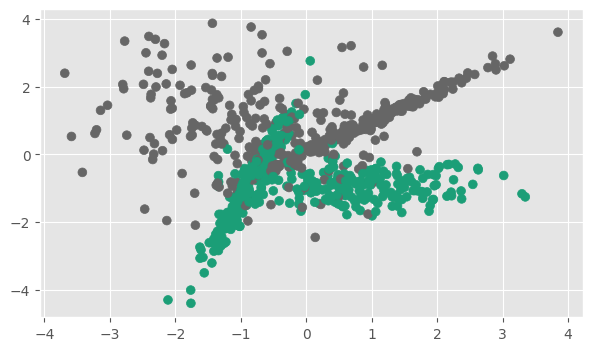

In [ ]:
# generate data
X, y = make_classification(
    n_samples = 1000, n_features = 2, n_classes = 2,
    n_informative = 2, n_redundant = 0, n_clusters_per_class = 2, class_sep = 0.85,
    random_state = SEED)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = SEED)

# plot data
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, s = 40);

---
## Centralized Model

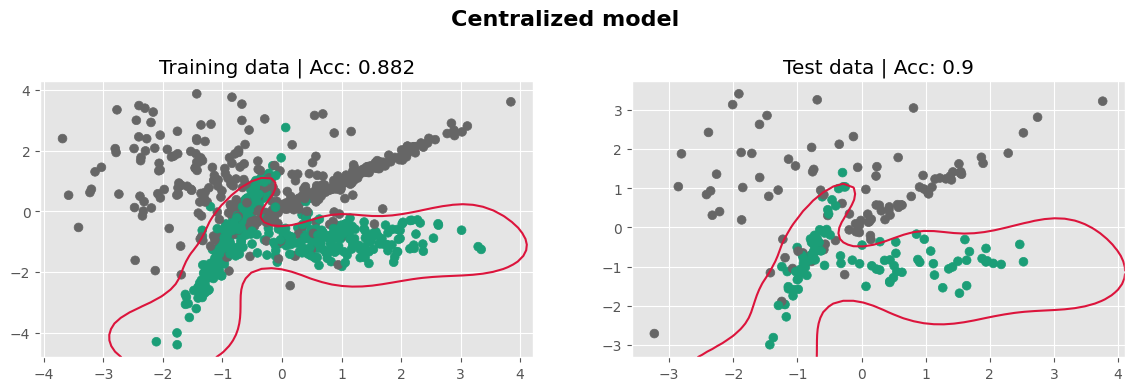

In [ ]:
# train a centralized model
centralized_model = deepcopy(MODEL)
centralized_model.fit(X_train, y_train)

# model metrics
train_acc = round(centralized_model.score(X_train, y_train), 3)
test_acc = round(centralized_model.score(X_test, y_test), 3)

# plot decision boundaries
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
fig.suptitle(f'Centralized model', fontsize = 16, fontweight = 'bold')
plt.subplots_adjust(top = 0.8)

ax[0].title.set_text(f'Training data | Acc: {train_acc}')
ax[0].scatter(X_train[:, 0], X_train[:, 1], c = y_train, s = 40)
plot_svc_decision_function(centralized_model, ax[0])

ax[1].title.set_text(f'Test data | Acc: {test_acc}')
ax[1].scatter(X_test[:, 0], X_test[:, 1], c = y_test, s = 40)
plot_svc_decision_function(centralized_model, ax[1])

---
## Active Learning

### Random Sampling

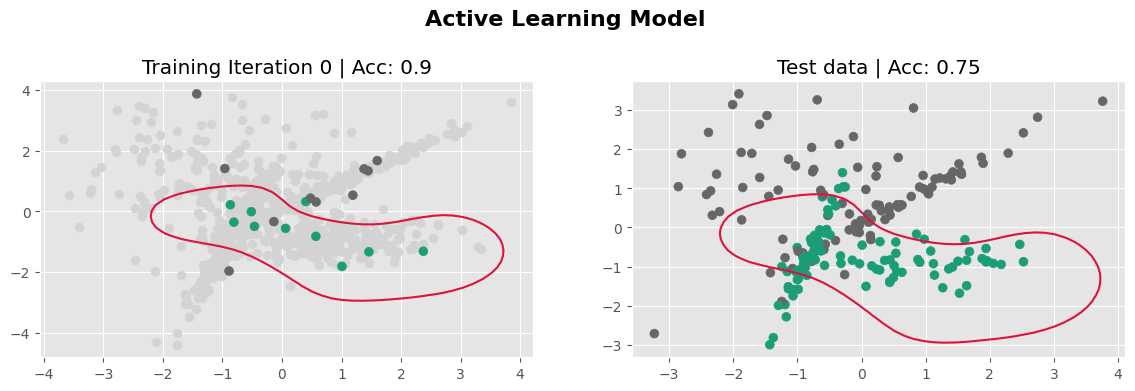

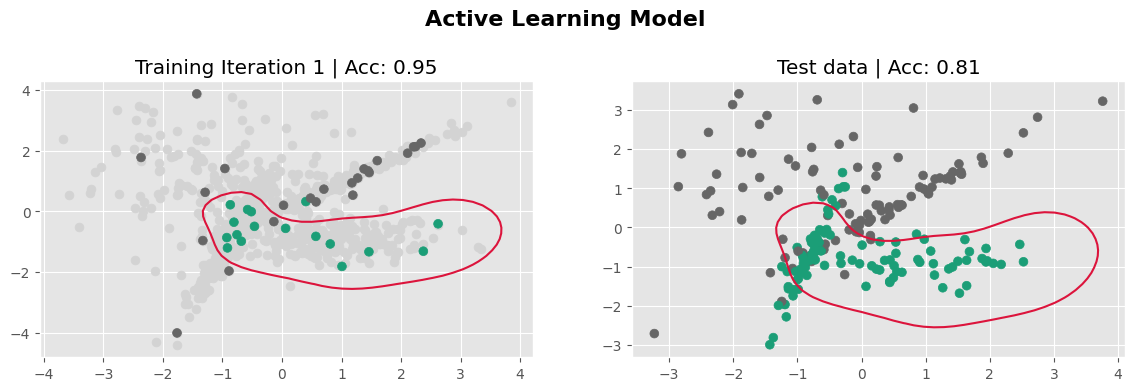

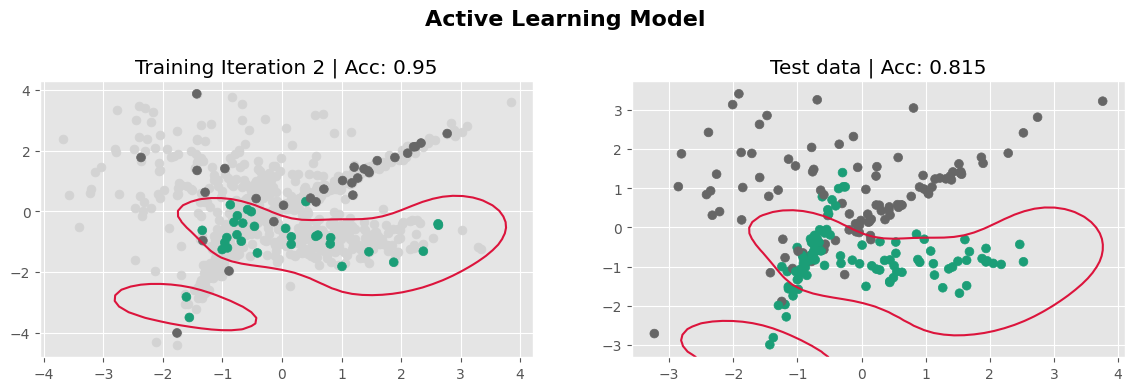

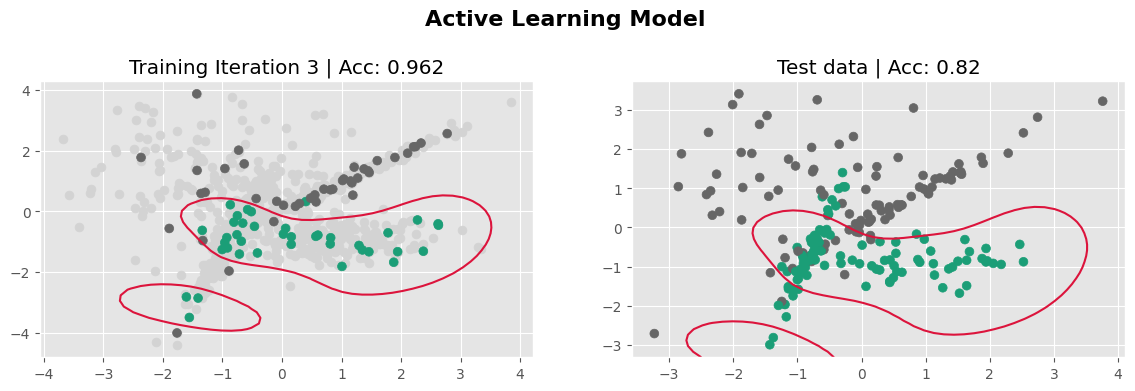

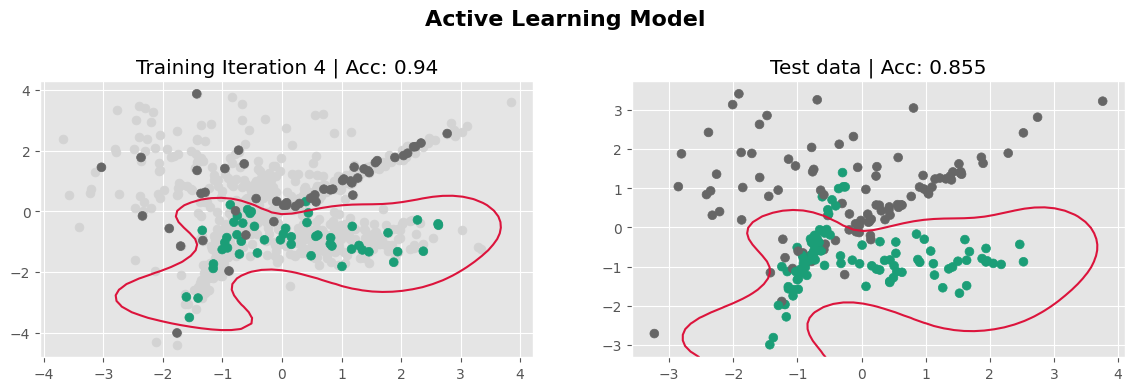

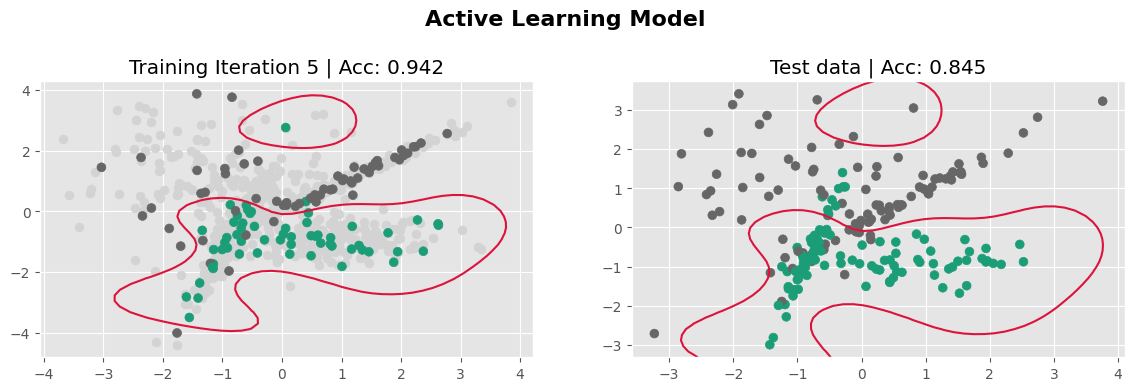

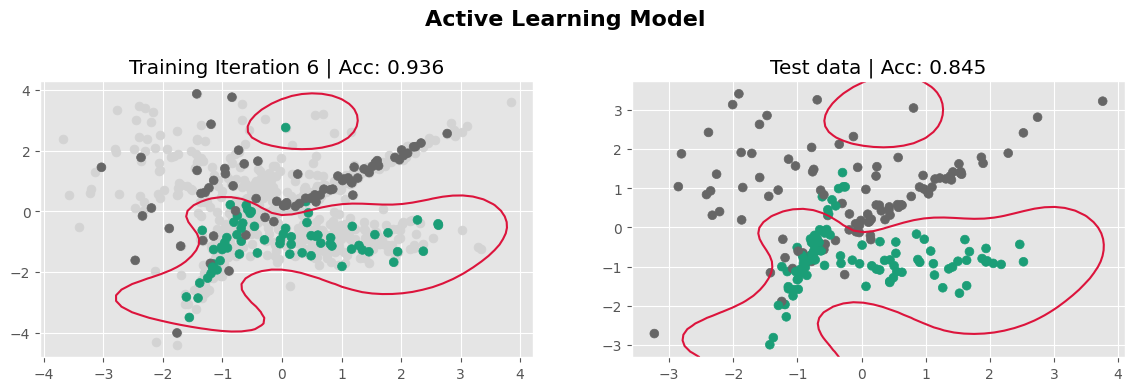

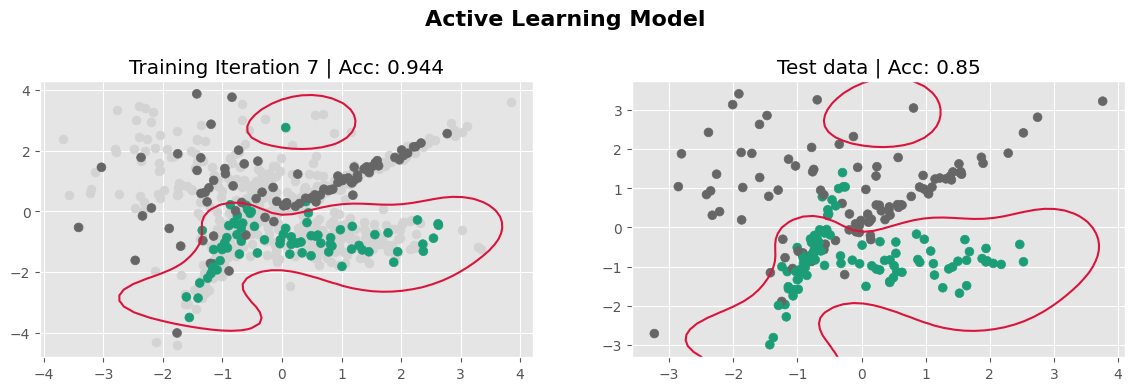

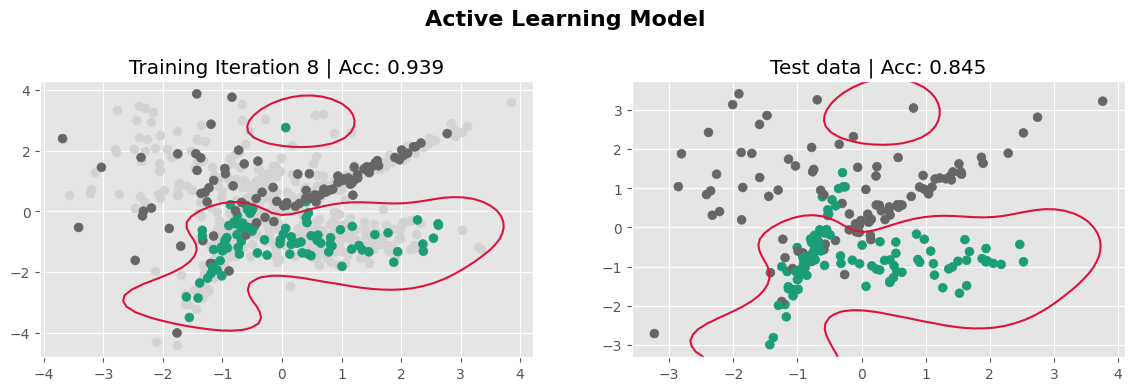

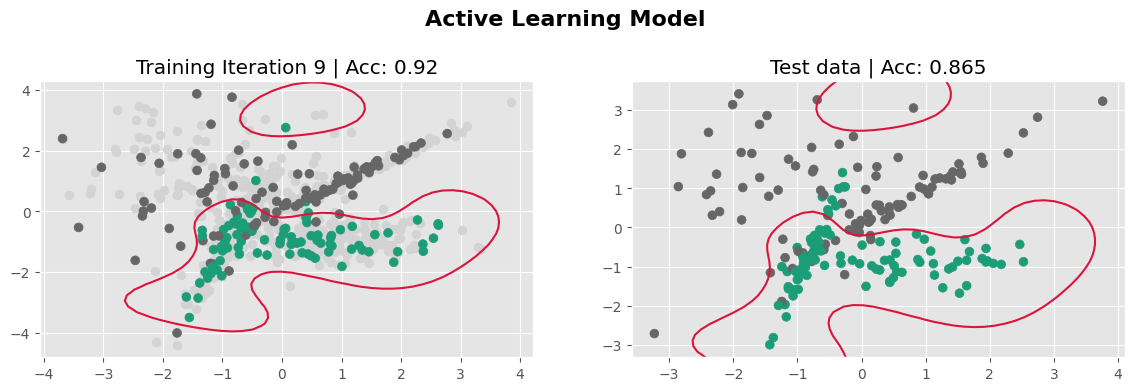

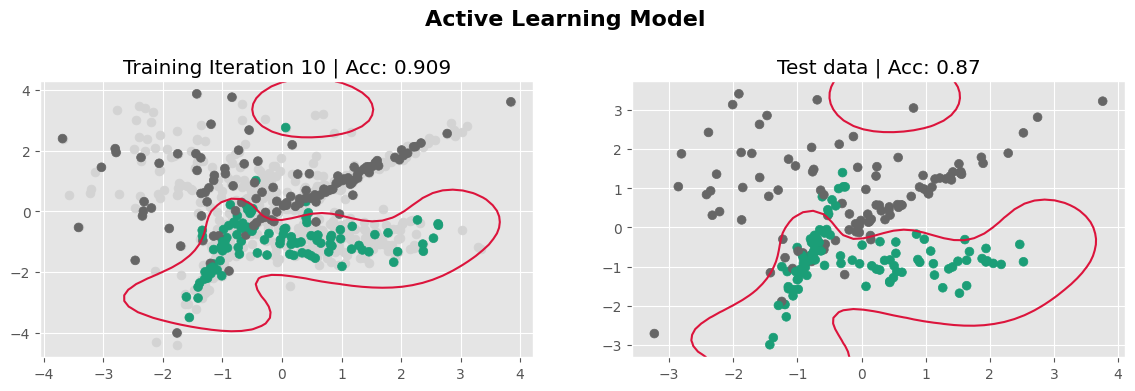

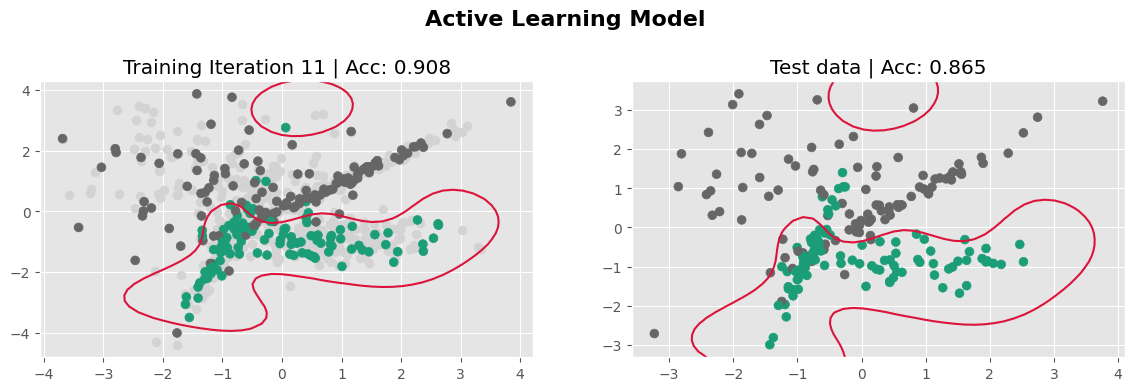

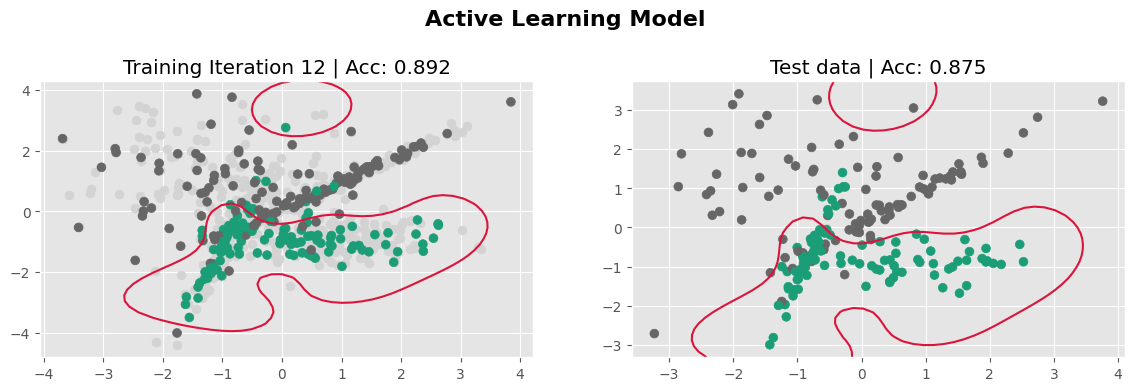

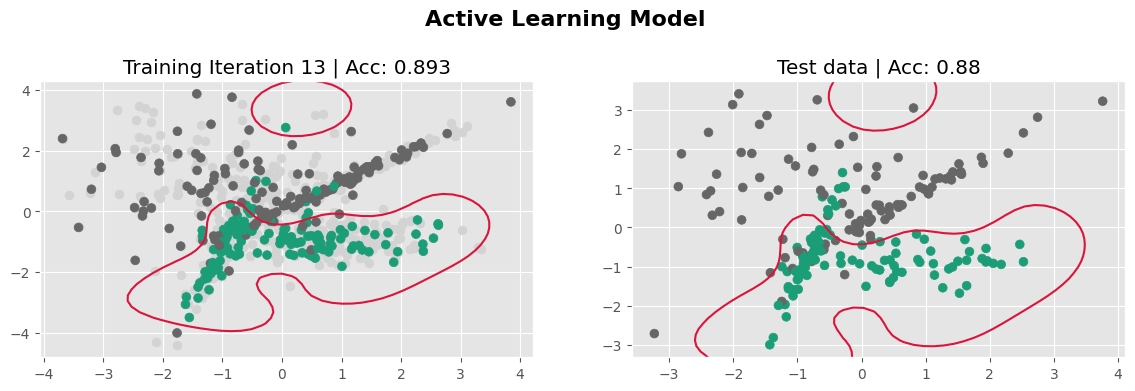

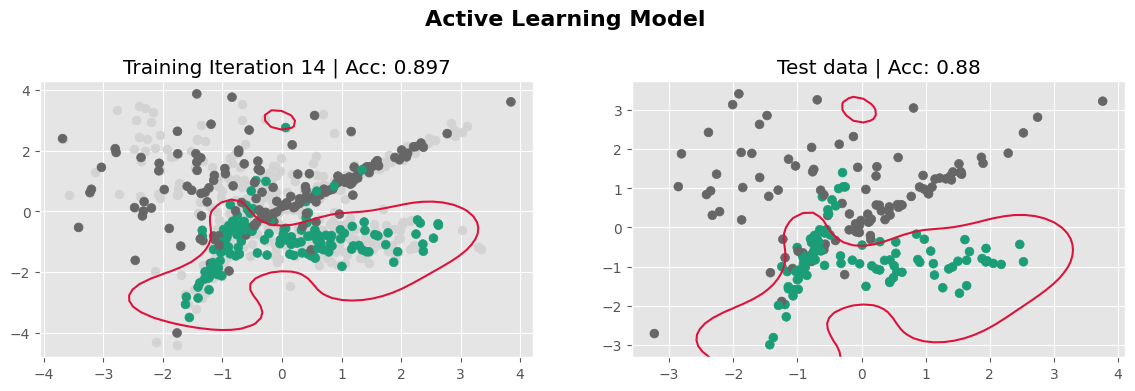

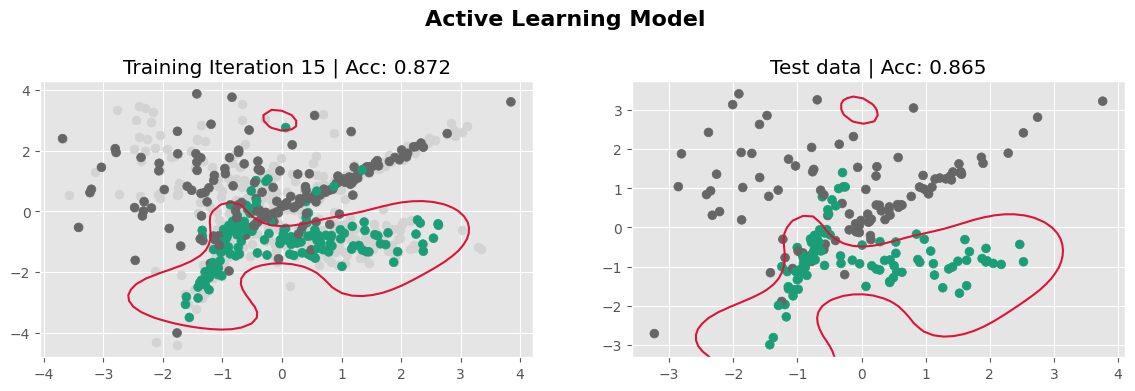

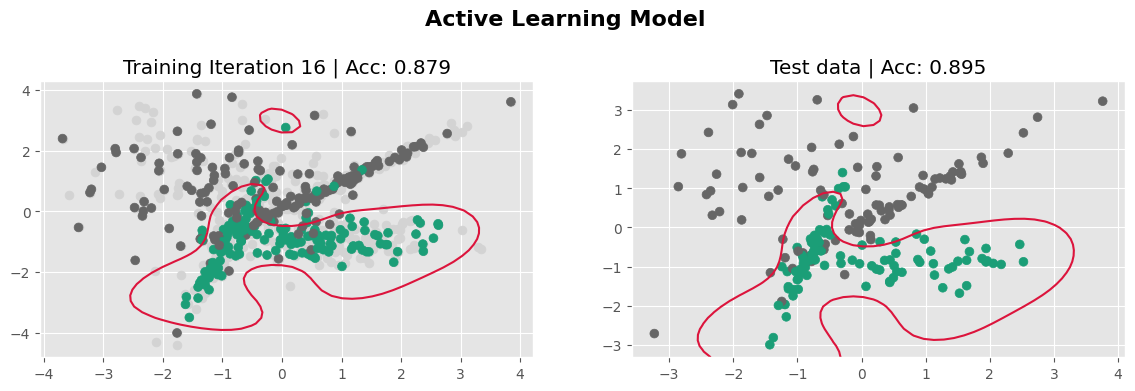

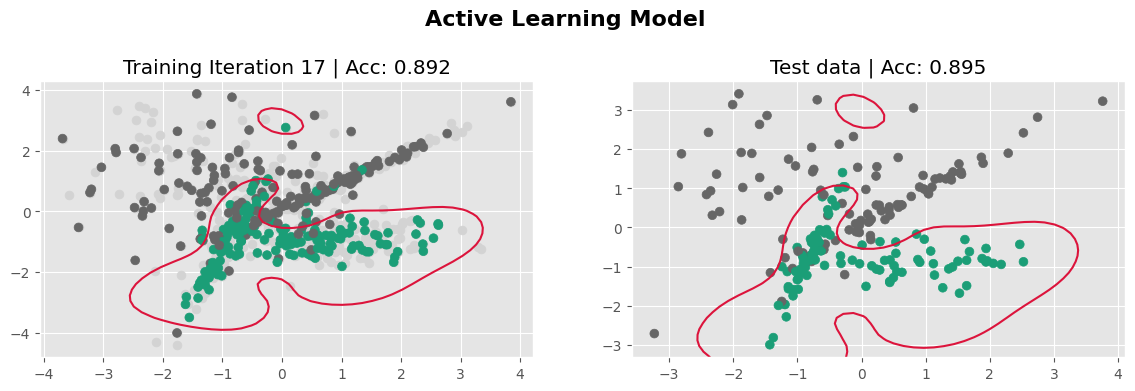

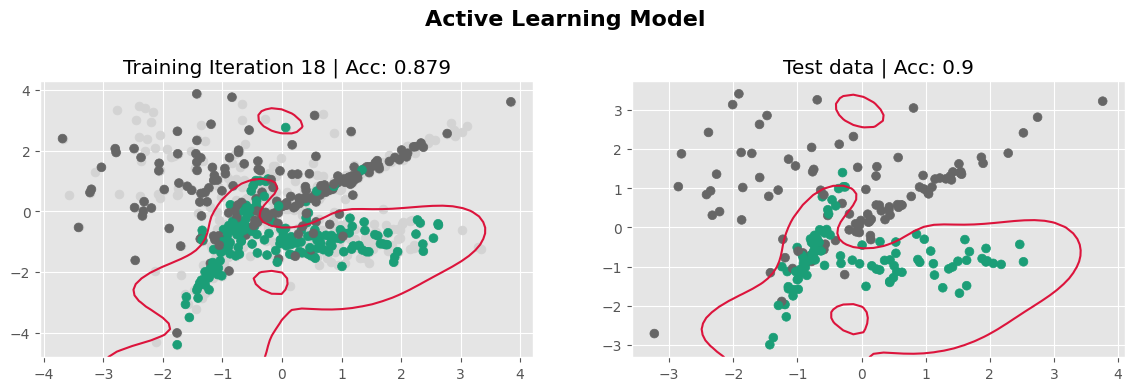

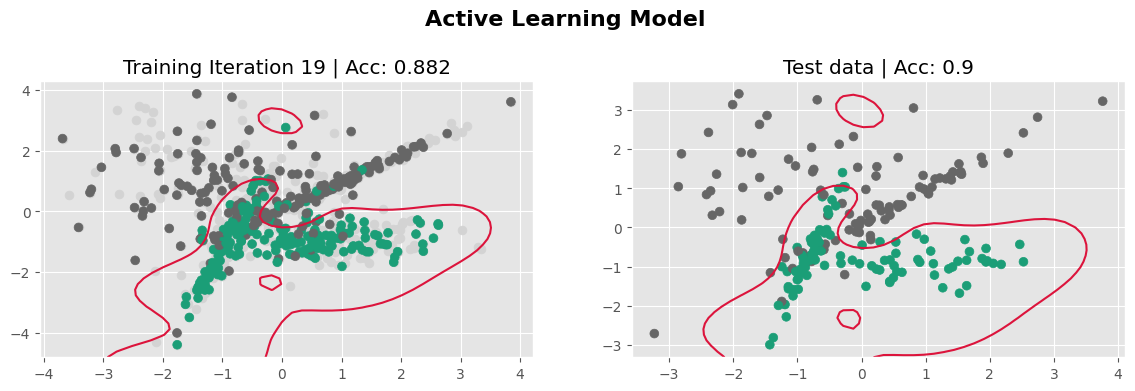

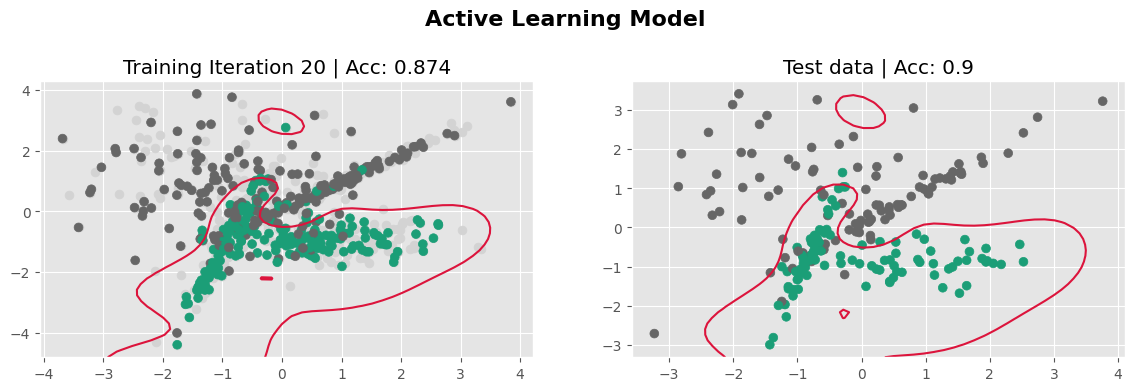

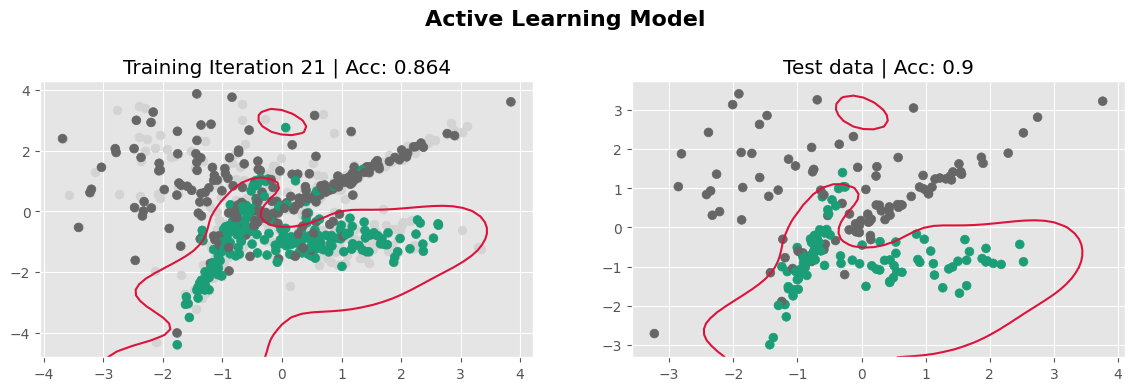

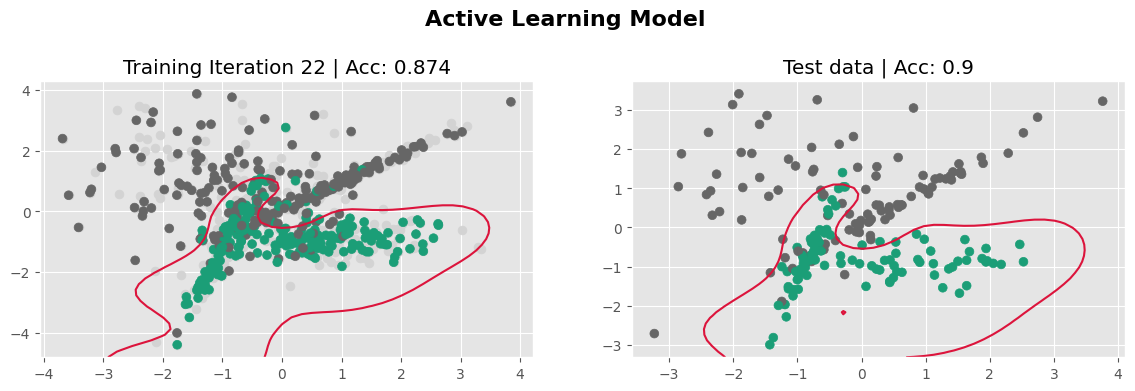

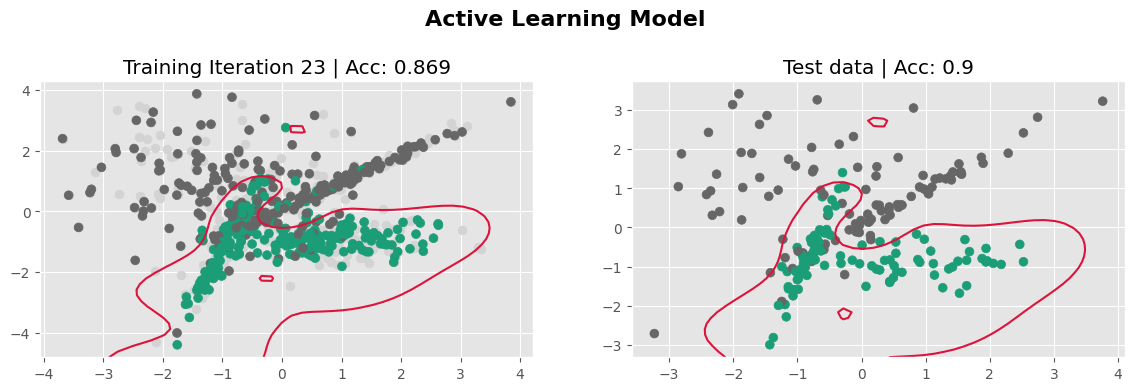

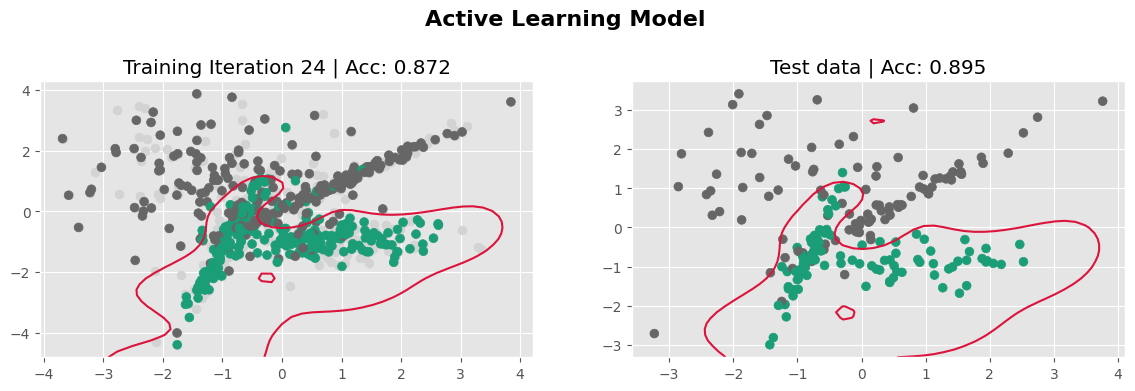

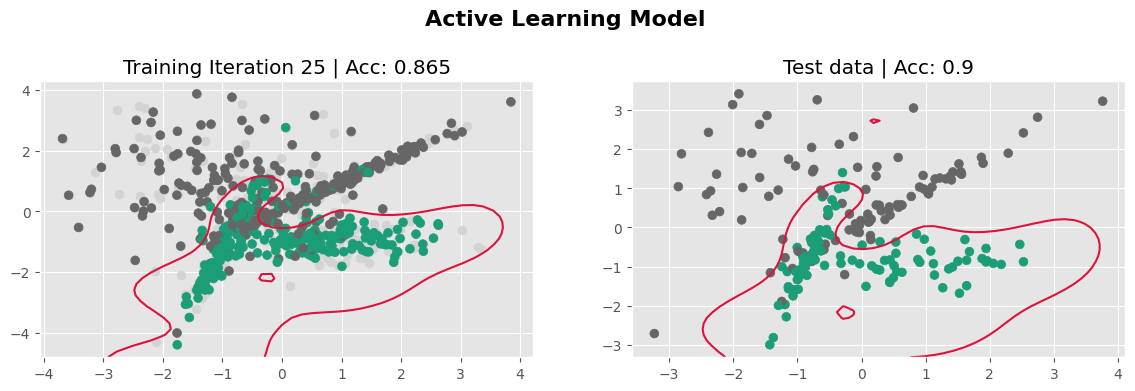

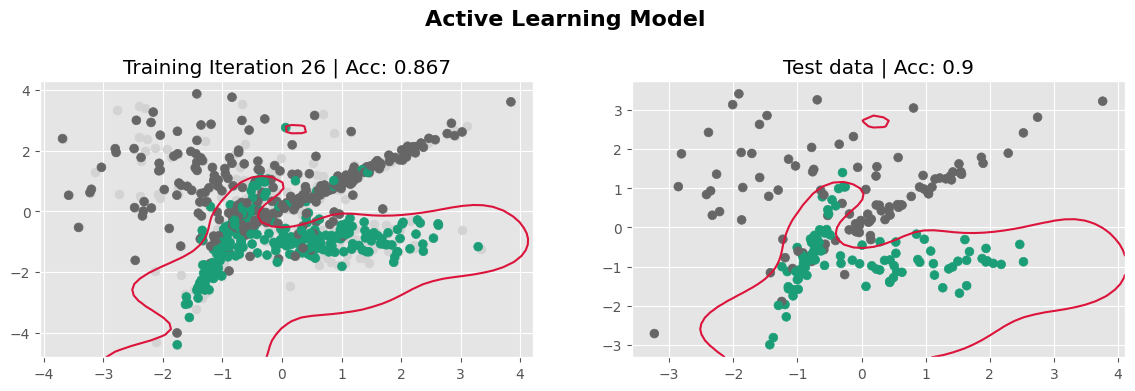

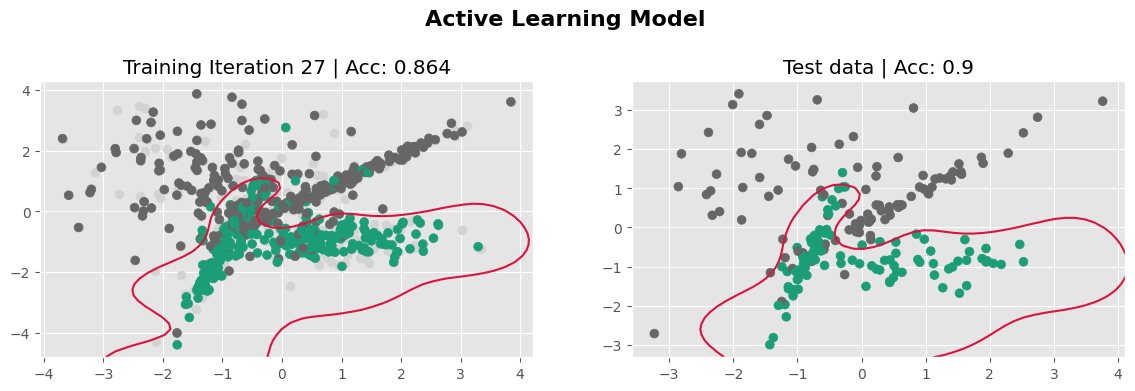

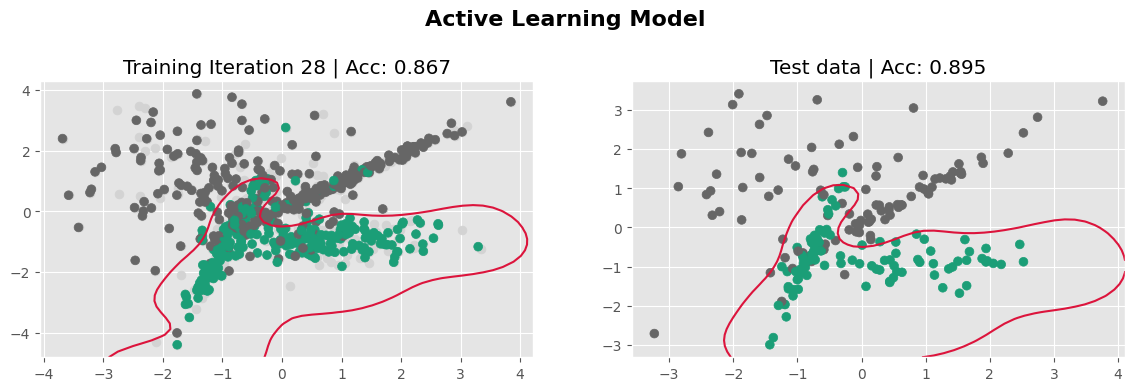

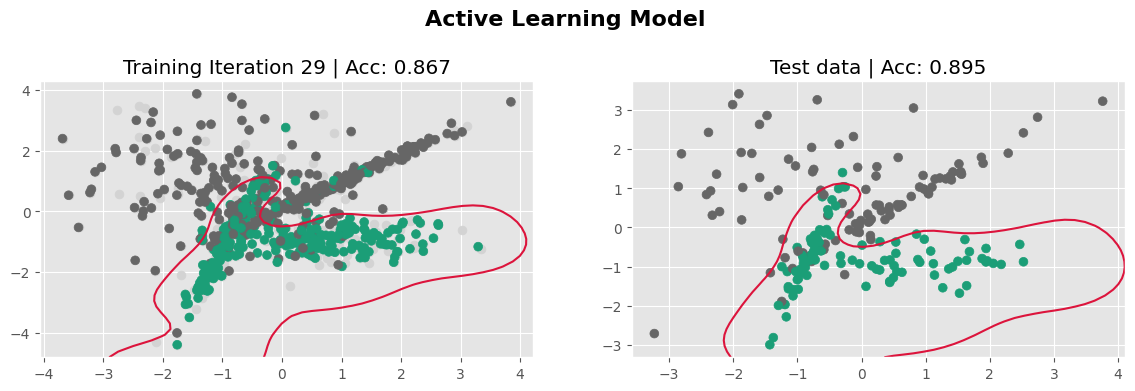

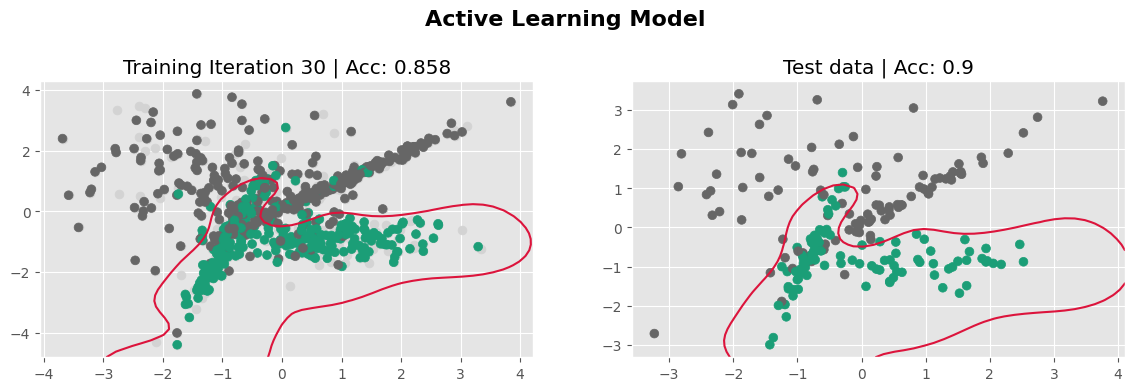

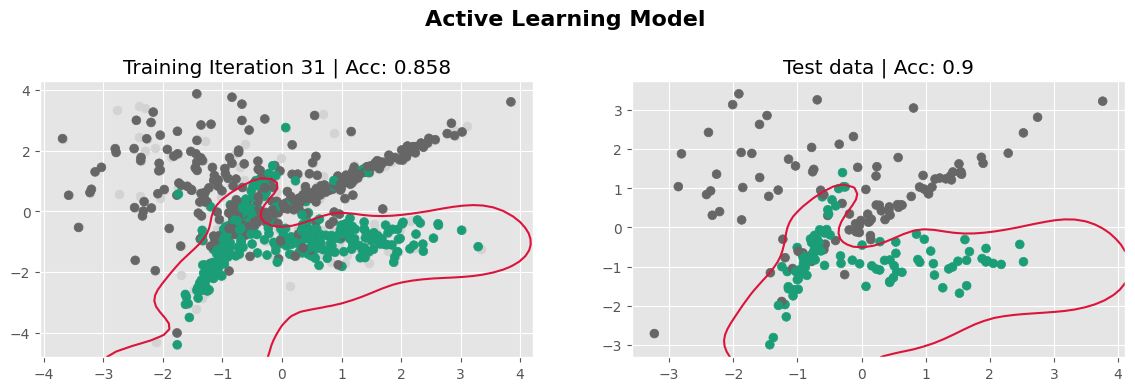

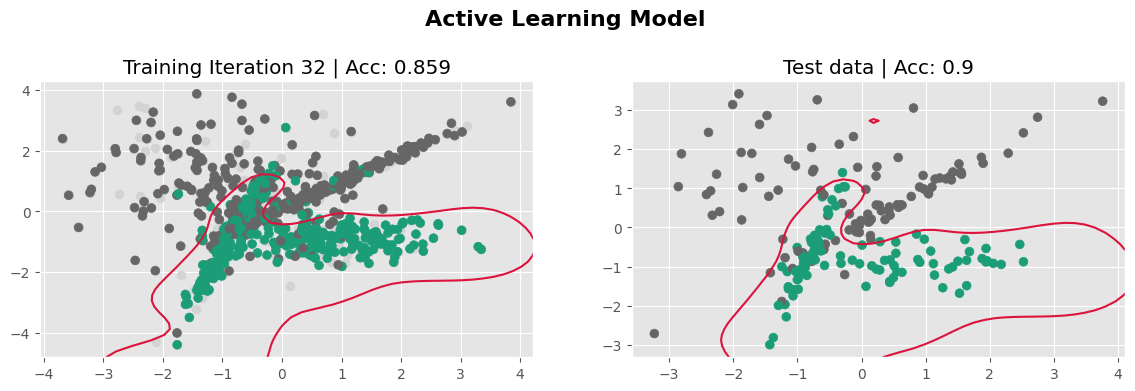

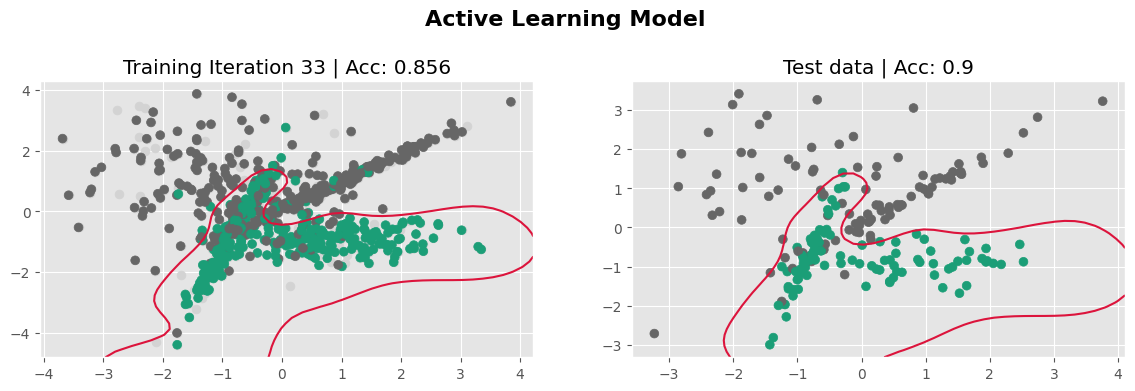

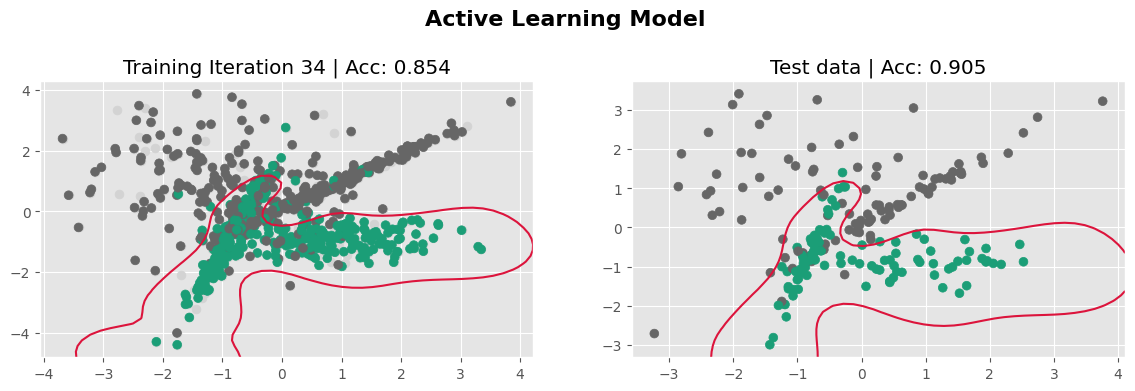

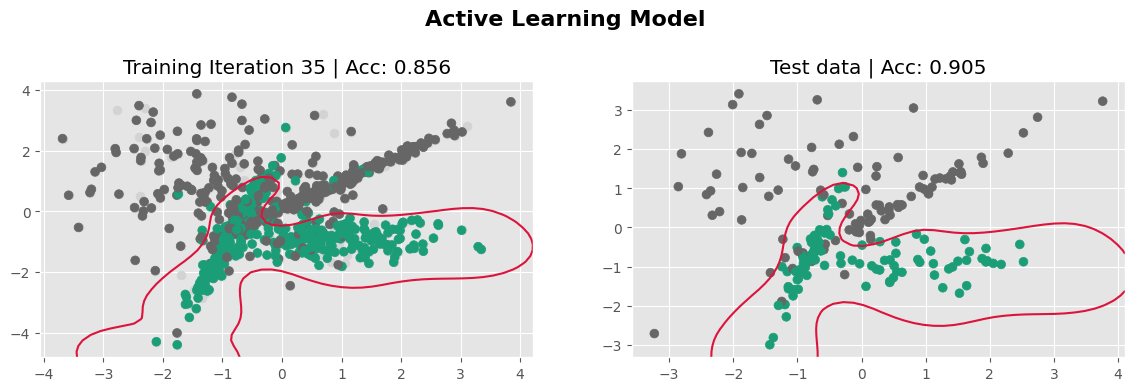

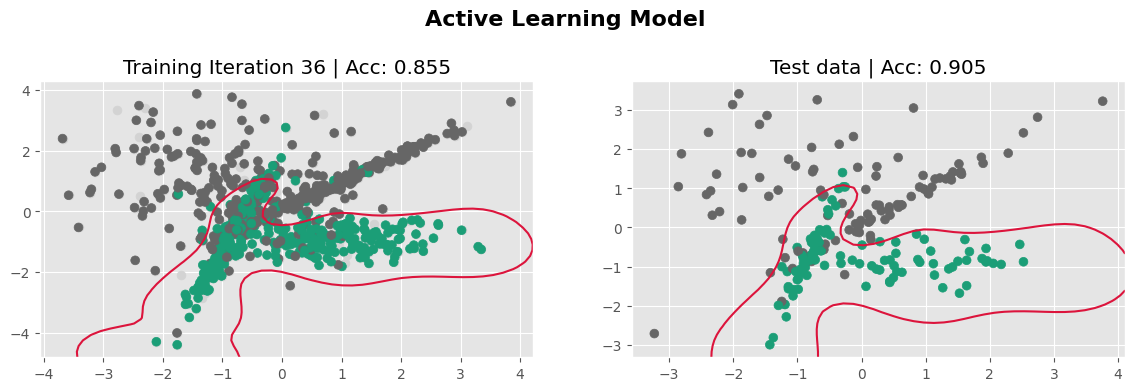

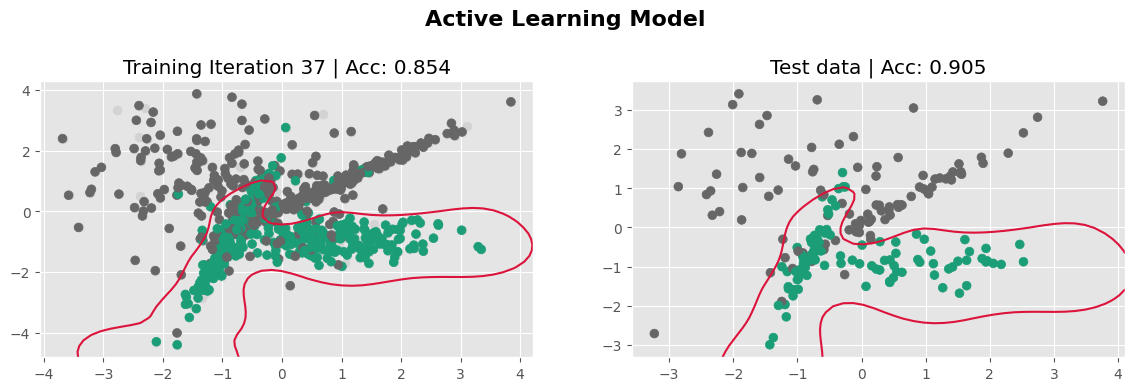

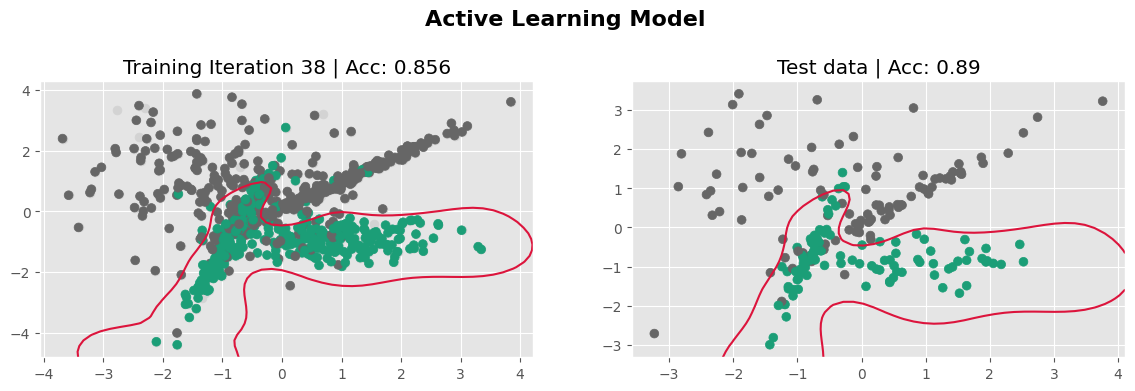

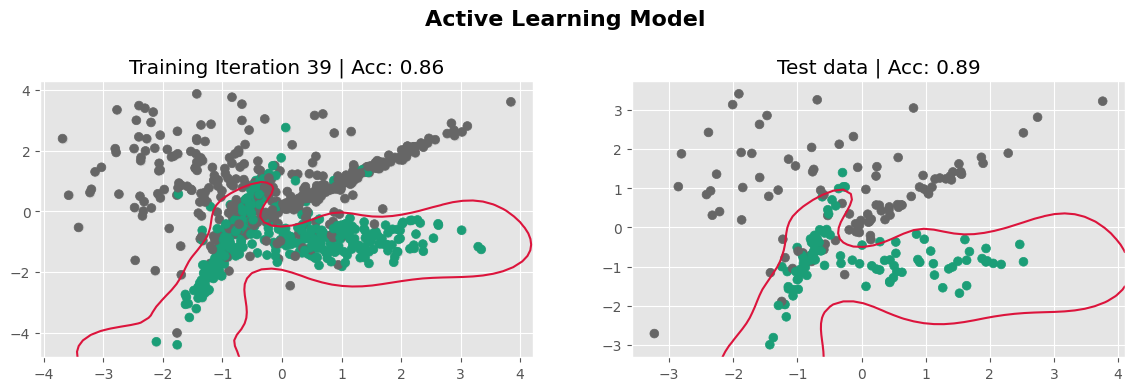

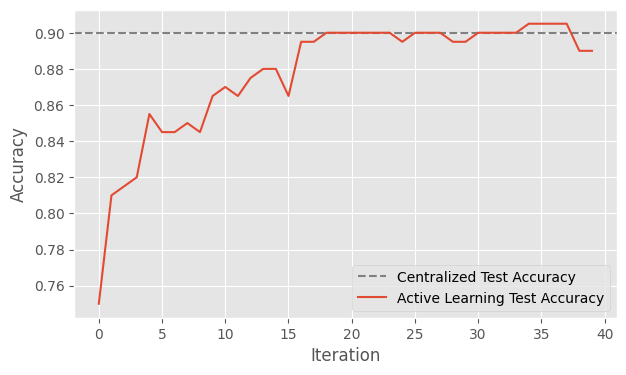

In [ ]:
# Reset seed to ensure same initial model
np.random.seed(SEED)

# Active Learning using Random Sampling
learner = ActiveLearner(
    X = X_train,
    y = y_train,
    model = deepcopy(MODEL),
    n_samples = N_SAMPLES,
    n_queries = N_QUERIES,
    strategy = 'random',
    human_error = HUMAN_ERROR
)

history = learner.fit()

plot_history(history, X_train, X_test, y_test, test_acc, show_models = True)

### Least Confidence Sampling

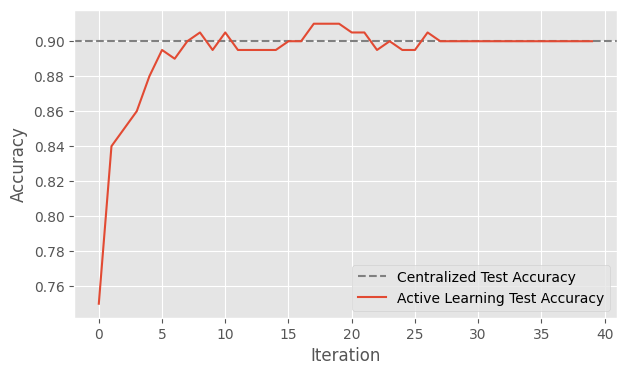

In [ ]:
# Reset seed to ensure same initial model
np.random.seed(SEED)

# Active Learning using least confidence sampling
learner = ActiveLearner(
    X = X_train,
    y = y_train,
    model = deepcopy(MODEL),
    n_samples = N_SAMPLES,
    n_queries = N_QUERIES,
    strategy = 'least_conf',
    human_error = HUMAN_ERROR
)

history = learner.fit()

plot_history(history, X_train, X_test, y_test, test_acc, show_models = False)

### Margin Confidence Sampling

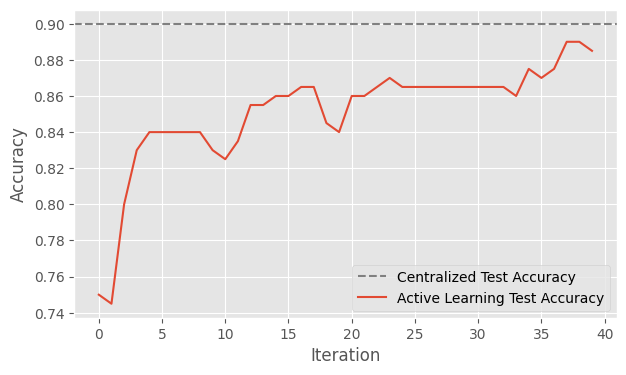

In [ ]:
# Reset seed to ensure same initial model
np.random.seed(SEED)

# Active Learning using margin confidence sampling
learner = ActiveLearner(
    X = X_train,
    y = y_train,
    model = deepcopy(MODEL),
    n_samples = N_SAMPLES,
    n_queries = N_QUERIES,
    strategy = 'margin_conf',
    human_error = HUMAN_ERROR
)

history = learner.fit()

plot_history(history, X_train, X_test, y_test, test_acc, show_models = False)

### Ratio Confidence Sampling

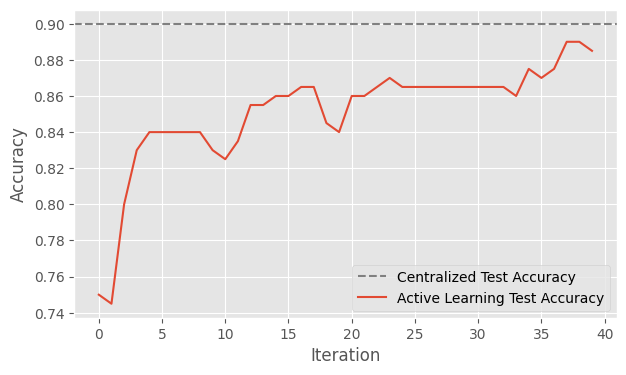

In [ ]:
# Reset seed to ensure same initial model
np.random.seed(SEED)

# Active Learning using ratio confidence sampling
learner = ActiveLearner(
    X = X_train,
    y = y_train,
    model = deepcopy(MODEL),
    n_samples = N_SAMPLES,
    n_queries = N_QUERIES,
    strategy = 'ratio_conf',
    human_error = HUMAN_ERROR
)

history = learner.fit()

plot_history(history, X_train, X_test, y_test, test_acc, show_models = False)

### Entropy Sampling

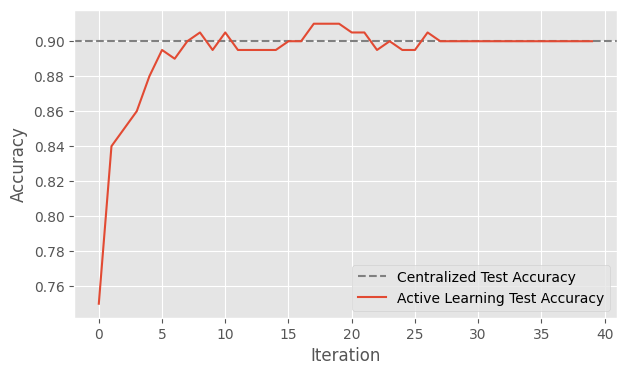

In [ ]:
# Reset seed to ensure same initial model
np.random.seed(SEED)

# Active Learning using entropy sampling
learner = ActiveLearner(
    X = X_train,
    y = y_train,
    model = deepcopy(MODEL),
    n_samples = N_SAMPLES,
    n_queries = N_QUERIES,
    strategy = 'entropy',
    human_error = HUMAN_ERROR
)

history = learner.fit()

plot_history(history, X_train, X_test, y_test, test_acc, show_models = False)